In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from nltk.stem.snowball import EnglishStemmer

## Data

First request: <br>
<b> SELECT Id, Score, Body,  Title, Tags FROM Posts WHERE  Title is not null and Tags is not null and Id<150000 </b>

In [5]:
df = pd.read_csv('D:/OP/P5/QueryResults_150.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17279 entries, 0 to 17278
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      17279 non-null  int64 
 1   Score   17279 non-null  int64 
 2   Body    17279 non-null  object
 3   Title   17279 non-null  object
 4   Tags    17279 non-null  object
dtypes: int64(2), object(3)
memory usage: 675.1+ KB


In [7]:
df.Score.describe()

count    17279.000000
mean        55.289484
std        279.984891
min         -7.000000
25%          2.000000
50%          7.000000
75%         22.000000
max       8615.000000
Name: Score, dtype: float64

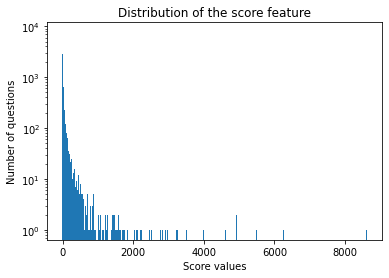

In [8]:
plt.hist(df.Score, bins=1000)
plt.yscale('log')
plt.xlabel('Score values')
plt.ylabel('Number of questions')
plt.title('Distribution of the score feature')
plt.show()

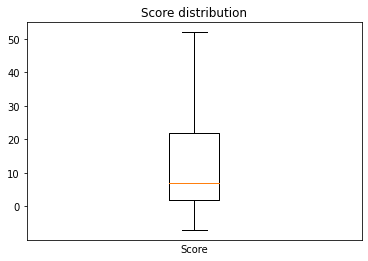

In [9]:
plt.boxplot(df.Score, showfliers=False)
plt.xticks([])
plt.xlabel('Score')
plt.title('Score distribution')
plt.show()

Second request adding a condition on the Score to have questions of good quality <br>
<b> SELECT Id, Score, Body,  Title, Tags FROM Posts WHERE  Title is not null and Tags is not null and Score>6 </b>

In [3]:
df = pd.read_csv('D:/OP/P5/QueryResults_score2.csv')

In [4]:
df.shape

(50000, 5)

We have 50000 questions.

## Data preparation

#### Body

In [11]:
# Remove html tags
df['body_clean'] = df.Body.str.replace(pat='<.*?>', repl='')

In [4]:
df.body_clean

0        I want to use a Track-Bar to change a Form's o...
1        I have an absolutely positioned div containing...
2        Given a DateTime representing a person's birth...
3        Given a specific DateTime value, how do I disp...
4        Is there a standard way for a web server to be...
                               ...                        
17274    Does anyone know of a method to determine when...
17275    I have an ASP.NET page which has a button it i...
17276    I have this problem, I'm using Castle ActiveRe...
17277    I had a problem that was partially solved. To ...
17278    I have a C++ program representing a TCP header...
Name: body_clean, Length: 17279, dtype: object

In [12]:
# lowercase
df.body_clean = df.body_clean.str.lower()

#### Tags

In [19]:
# remove <>
tags = df.Tags.str.extractall(r'<(.*?)>')

In [20]:
tags[0][0].str.cat(sep=' ')

'angular ionic2 ionic3 ionic2-providers'

In [21]:
df['tags_clean'] = tags.groupby(level=0).agg({0: ' '.join})

In [22]:
# lowercase
df['tags_clean'] = df['tags_clean'].str.lower()

#### Title

In [17]:
# lower
df.Title = df.Title.str.lower()

In [10]:
df.head()

,Id,Score,Body,Title,Tags,body_clean,tags_clean
0,4,728,<p>I want to use a <code>Track-Bar</code> to c...,how to convert a decimal to a double in c#?,<c#><floating-point><type-conversion><double><...,I want to use a Track-Bar to change a Form's o...,c# floating-point type-conversion double decimal
1,6,306,<p>I have an absolutely positioned <code>div</...,why did the width collapse in the percentage w...,<html><css><internet-explorer-7>,I have an absolutely positioned div containing...,html css internet-explorer-7
2,9,2035,<p>Given a <code>DateTime</code> representing ...,how do i calculate someone's age based on a da...,<c#><.net><datetime>,Given a DateTime representing a person's birth...,c# .net datetime
3,11,1581,<p>Given a specific <code>DateTime</code> valu...,calculate relative time in c#,<c#><datetime><time><datediff><relative-time-s...,"Given a specific DateTime value, how do I disp...",c# datetime time datediff relative-time-span
4,13,656,<p>Is there a standard way for a web server to...,determine a user's timezone,<html><browser><timezone><user-agent><timezone...,Is there a standard way for a web server to be...,html browser timezone user-agent timezone-offset


### Length of Body and Title

In [89]:
# get body length
df['body_length'] = df.body_clean.apply(len)

In [13]:
df.body_length.describe()

count    17279.000000
mean       634.789398
std        692.184592
min         14.000000
25%        261.000000
50%        456.000000
75%        788.000000
max      27659.000000
Name: body_length, dtype: float64

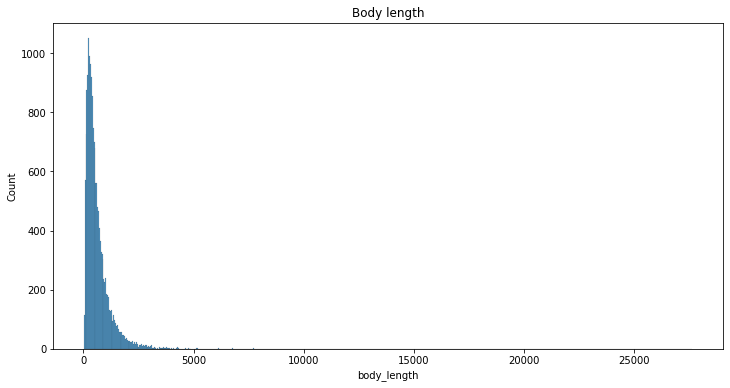

In [14]:
fig = plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='body_length')
plt.title('Body length')
plt.show()

The majority of the bodies have a length inferior at 1000 but there are som bodies with a length up to 27000.

In [90]:
df.Title.fillna('', inplace=True)

In [91]:
df['title_length'] = df.Title.apply(len)

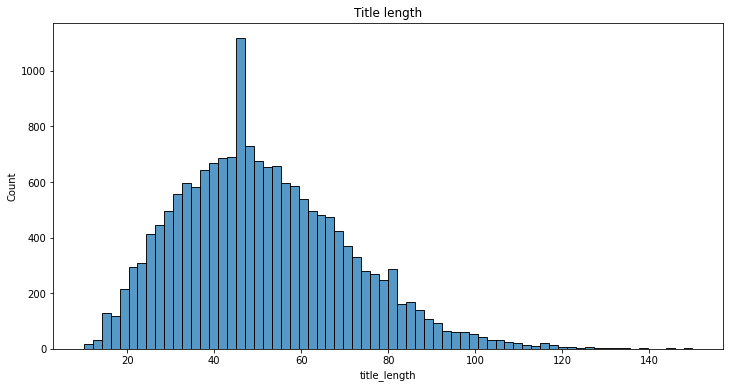

In [17]:
fig = plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='title_length')
plt.title('Title length')
plt.show()

We can see that the title are not very long with a mean of 50 characters. The longest is 150.

#### remove punctuation

In [5]:
import string
punctuation = string.punctuation

In [19]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [92]:
df.body_clean = df.body_clean.str.replace('[{}]'.format(punctuation),'')

#### remove stopwords

In [6]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elodi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [93]:
def remove_stopwords_sentence(sentence):
    """Remove the stopwords from a sentence"""
    return [word for word in sentence.split() if word not in stop]

In [94]:
%%time
df['body_clean_stopwords'] = df.body_clean.apply(remove_stopwords_sentence)

Wall time: 3.61 s


In [24]:
df.head()

,Id,Score,Body,Title,Tags,body_clean,tags_clean,body_length,title_length,body_clean_stopwords
0,4,727,<p>I want to use a <code>Track-Bar</code> to c...,how to convert a decimal to a double in c#?,<c#><floating-point><type-conversion><double><...,i want to use a trackbar to change a forms opa...,c# floating-point type-conversion double decimal,366,43,"[want, use, trackbar, change, forms, opacity, ..."
1,6,306,<p>I have an absolutely positioned <code>div</...,why did the width collapse in the percentage w...,<html><css><internet-explorer-7>,i have an absolutely positioned div containing...,html css internet-explorer-7,512,123,"[absolutely, positioned, div, containing, seve..."
2,9,2033,<p>Given a <code>DateTime</code> representing ...,how do i calculate someone's age based on a da...,<c#><.net><datetime>,given a datetime representing a persons birthd...,c# .net datetime,90,67,"[given, datetime, representing, persons, birth..."
3,11,1581,<p>Given a specific <code>DateTime</code> valu...,calculate relative time in c#,<c#><datetime><time><datediff><relative-time-s...,given a specific datetime value how do i displ...,c# datetime time datediff relative-time-span,109,29,"[given, specific, datetime, value, display, re..."
4,13,656,<p>Is there a standard way for a web server to...,determine a user's timezone,<html><browser><timezone><user-agent><timezone...,is there a standard way for a web server to be...,html browser timezone user-agent timezone-offset,166,27,"[standard, way, web, server, able, determine, ..."


In [95]:
df['title_clean_stopwords'] = df.Title.apply(remove_stopwords_sentence)

### WordClouds 

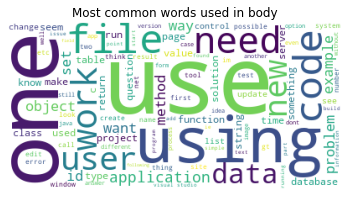

In [96]:
from wordcloud import WordCloud
# Wordcloud of body
wordcloud1 = WordCloud(background_color='white', max_words=100).generate(
    ' '.join(df.body_clean_stopwords.apply(lambda x: ' '.join(x))))
plt.imshow(wordcloud1)
plt.title('Most common words used in body')
plt.axis("off")
plt.show()

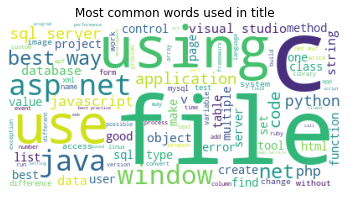

In [34]:
# wordcloud of title
wordcloud2 = WordCloud(background_color='white', max_words=100).generate(
    ' '.join(df.title_clean_stopwords.apply(lambda x: ' '.join(x))))
plt.imshow(wordcloud2)
plt.title('Most common words used in title')
plt.axis("off")
plt.show()

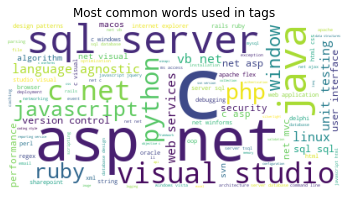

In [36]:
# wordcloud of tags
wordcloud3 = WordCloud(background_color='white',
                       max_words=100).generate(' '.join(df.tags_clean))
plt.imshow(wordcloud3)
plt.title('Most common words used in tags')
plt.axis("off")
plt.show()

### Study tags

In [9]:
# Transform the tags into list of tags
tags_list = df.tags_clean.apply(str.split).tolist()

In [10]:
# get all tags in one list
tags_list = [item for sublist in tags_list for item in sublist]

In [11]:
from collections import Counter
# Count each tag
count_tags = Counter(tags_list)

In [12]:
count_tags = pd.DataFrame.from_dict(count_tags, orient='index')

In [15]:
count_tags

,0
c#,1579
floating-point,25
type-conversion,9
double,4
decimal,5
...,...
jsch,1
program-transformation,1
optional-parameters,1
pattern-matching,1


In [13]:
# sort the tags
count_tags.sort_values(by=0, inplace=True, ascending=False)
count_tags.reset_index(inplace=True)

In [14]:
count_tags.rename(columns={'index': 'tags', 0: 'nb'}, inplace=True)

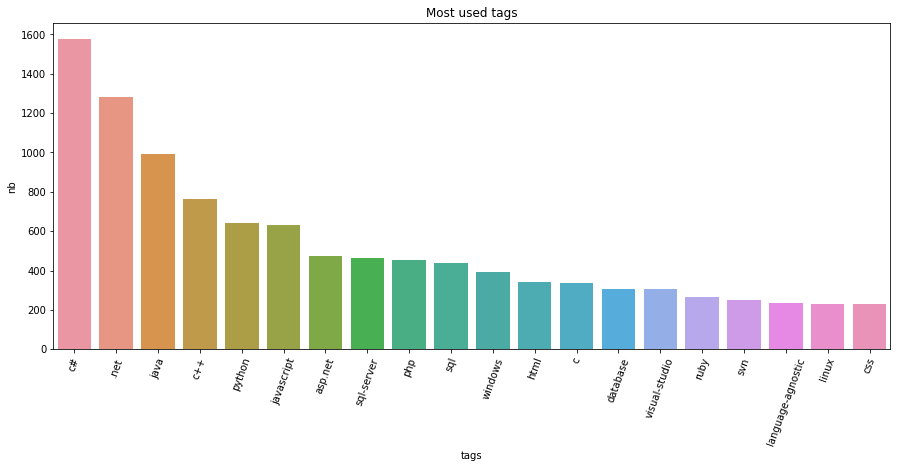

In [15]:
# Plot the most commons tags
fig = plt.figure(figsize=(15, 6))
sns.barplot(data=count_tags[:20], x='tags', y='nb')
plt.title('Most used tags')
plt.xticks(rotation=70)
plt.show()

We can see that in the most commons tags there are a lot of programming languages.

In [20]:
# Get the tags that have more than 7 occurences
most_common_tags = count_tags.loc[count_tags.nb > 7]
print('Number of tags  ', most_common_tags.shape[0])
print('Number of samples  ', most_common_tags.nb.sum())

Number of tags   630
Number of samples   28223


In [130]:
# get the top 5 of commons tags
most_common_tags_5 = count_tags[:5].tags.tolist()

### Top 5 tags : wordclouds of title and body

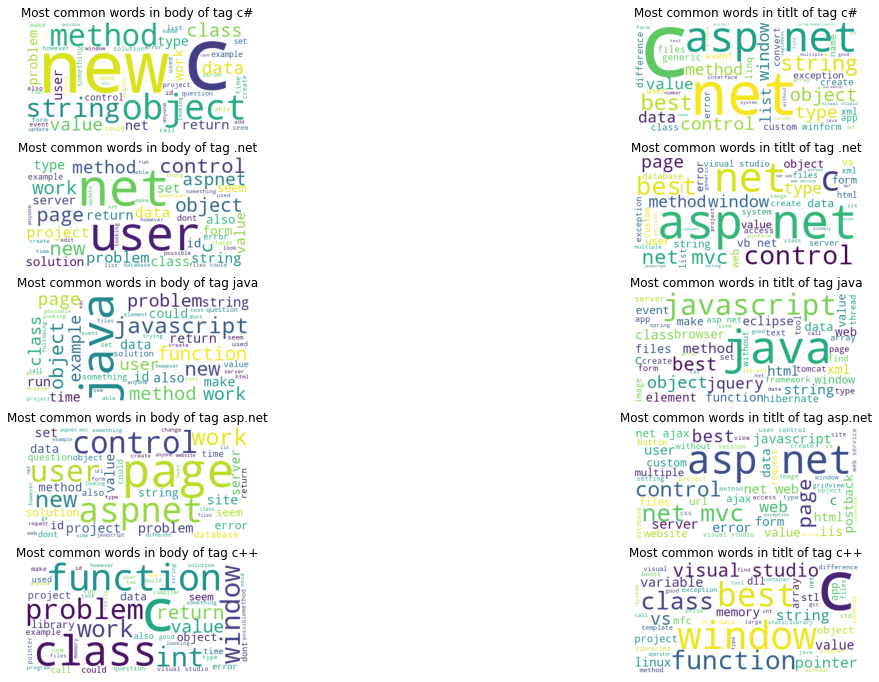

In [140]:
fig, ax = plt.subplots(5, 2, figsize=(20, 12))
i = 0
for t in most_common_tags_5:
    df_t = df.loc[df.tags_clean.str.contains(t, regex=False)]

    wordcloud11 = WordCloud(background_color='white', max_words=50, stopwords=words_to_remove).generate(
        ' '.join(df_t.body_clean_stopwords.apply(lambda x: ' '.join(x))))
    ax[i][0].imshow(wordcloud11)
    ax[i][0].set_title('Most common words in body of tag ' + t)
    ax[i][0].axis("off")

    wordcloud12 = WordCloud(background_color='white', max_words=50, stopwords=words_to_remove).generate(
        ' '.join(df_t.title_clean_stopwords.apply(lambda x: ' '.join(x))))
    ax[i][1].imshow(wordcloud12)
    ax[i][1].set_title('Most common words in titlt of tag ' + t)
    ax[i][1].axis("off")

    i += 1
plt.show()

### Programming languages

In [11]:
df_tags = pd.read_csv('D:/OP/P5/tags_programming_languages.csv')

In [12]:
df_tags.Tags

0                         .net
1                     .net-1.1
2                     .net-2.0
3                     .net-3.5
4                     .net-4.0
                ...           
179    visual-c++-2008-express
180            visual-c++-2010
181            visual-c++-2013
182               visual-c++-6
183                        xml
Name: Tags, Length: 184, dtype: object

In [13]:
import re
# extract programming language from the tag
tags_extract = df_tags.Tags.apply(
    lambda x: re.match('(\.?[a-z]+)', str(x)).group())

In [15]:
tags_extract.unique().shape

(74,)

In [23]:
# check all tags sequence and keep samples with a tag in the programming languages 
df_prog = df.loc[df.tags_clean.apply(check_sentence, list_tags=df_tags.Tags.to_list())]

In [24]:
df_prog.shape

(31666, 6)

In [54]:
# save df prog
df_prog.to_csv('D:/OP/P5/df_prog.csv')

In [20]:
# get the programming tags 
tags_prog = df_prog.tags_clean.apply(lambda x : simplify_tags_sentence(x,df_tags.Tags.to_list()))

In [21]:
# create the tf idf for the tags
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer()
tags_vectors = vect.fit_transform(tags_prog.apply(lambda x : ','.join(x)))

In [22]:
vect.get_feature_names()

['ada',
 'angular',
 'applescript',
 'asp',
 'awk',
 'bash',
 'batch',
 'beta',
 'coffeescript',
 'coldfusion',
 'coq',
 'csh',
 'css',
 'curl',
 'cython',
 'dart',
 'darwin',
 'delphi',
 'ecmascript',
 'elixir',
 'elm',
 'emacs',
 'erlang',
 'factor',
 'fish',
 'flex',
 'focus',
 'fortran',
 'gnu',
 'go',
 'groovy',
 'haskell',
 'html',
 'io',
 'java',
 'javafx',
 'javascript',
 'jquery',
 'json',
 'julia',
 'jython',
 'kotlin',
 'linq',
 'lisp',
 'machine',
 'matlab',
 'max',
 'mysql',
 'net',
 'ocaml',
 'octave',
 'opencl',
 'pascal',
 'perl',
 'php',
 'postscript',
 'powershell',
 'processing',
 'prolog',
 'python',
 'ruby',
 'scala',
 'spark',
 'sql',
 'verilog',
 'vhdl',
 'visual',
 'xml']

In [53]:
tags_vectors

<31680x90 sparse matrix of type '<class 'numpy.float64'>'
	with 29408 stored elements in Compressed Sparse Row format>

#### use kmeans to see tags appearing together

In [41]:
from sklearn.cluster import KMeans, DBSCAN
from yellowbrick.cluster import KElbowVisualizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

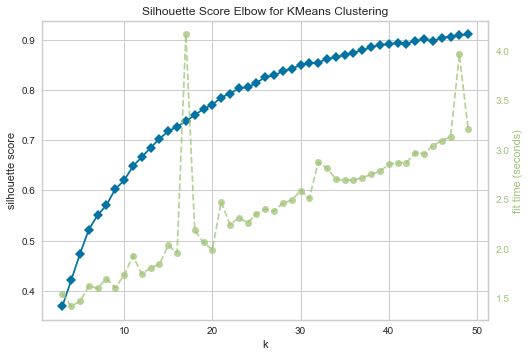

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [54]:
# choose the optimal k
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3, 50), locate_elbow=False, metric='silhouette')

visualizer.fit(tags_vectors)        
visualizer.show()

In [55]:
kmeans = KMeans(n_clusters =20, init='k-means++' ).fit(tags_vectors)
labs = kmeans.labels_

In [87]:
from wordcloud import WordCloud


def word_clouds(labels, tags_corpus, optimal_k):
    """Plot the wordclouds for each cluster"""
    
    clusters_dict = {i: np.where(labels == i)[0] for i in range(optimal_k)}

    clusters_list = []
    print("The number of datapoints in each cluster are as follows : ")
    for key, value in clusters_dict.items():
        temp = [key, value]
        clusters_list.append(temp)
        print("Cluster = {}, Number of data points = {}".format(key+1, len(value)))

    fig, ax = plt.subplots(optimal_k//2, 2, figsize=(20, 12))
    j = 0
    k = 0
    for cluster_number in range(optimal_k):
        cluster = [clusters_dict[cluster_number][a]
                   for a in range(clusters_dict[cluster_number].size)]

        reviews_cluster = []
        for i in cluster:
            reviews_cluster.append(tags_corpus[i])

        review_corpus = ""
        for review in np.unique(np.array(reviews_cluster)):
            review_corpus = review_corpus + " " + review

        
        wordcloud = WordCloud(max_words=15,
                              min_font_size=4, random_state=42, background_color='white',
                              contour_color='black', repeat=False).generate(str(review_corpus))

        ax[j][k].set_title(
            "Word Cloud for Cluster {}".format(cluster_number+1))
        ax[j][k].imshow(wordcloud)
        ax[j][k].axis("off")

        if j+1 == optimal_k//2:
            j = 0
            k = 1
        else:
            j += 1
    plt.show()

The number of datapoints in each cluster are as follows : 
Cluster = 1, Number of data points = 9015
Cluster = 2, Number of data points = 4104
Cluster = 3, Number of data points = 3635
Cluster = 4, Number of data points = 1683
Cluster = 5, Number of data points = 2149
Cluster = 6, Number of data points = 1242
Cluster = 7, Number of data points = 1805
Cluster = 8, Number of data points = 967
Cluster = 9, Number of data points = 809
Cluster = 10, Number of data points = 802
Cluster = 11, Number of data points = 1192
Cluster = 12, Number of data points = 394
Cluster = 13, Number of data points = 381
Cluster = 14, Number of data points = 840
Cluster = 15, Number of data points = 829
Cluster = 16, Number of data points = 290
Cluster = 17, Number of data points = 282
Cluster = 18, Number of data points = 444
Cluster = 19, Number of data points = 398
Cluster = 20, Number of data points = 419


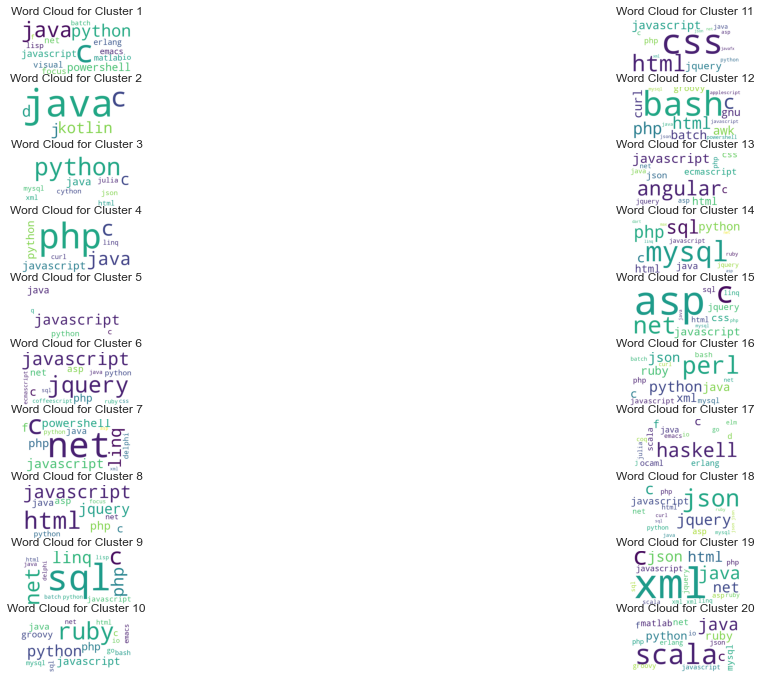

In [88]:
word_clouds(labs, tags_prog.apply(lambda x : ','.join(x)).reset_index(drop=True), 20)

#### Most used tags 

In [40]:
# transform the tags into a list of tags
tags_prog_list = [item for t in tags_prog.to_list() for item in t]

In [41]:
from collections import Counter
# count the number of occurences of each tags
count_tags_prog = Counter(tags_prog_list)

In [42]:
count_tags_prog = pd.DataFrame.from_dict(count_tags_prog, orient='index')

In [43]:
# sort the tags by count
count_tags_prog.sort_values(by=0, inplace=True, ascending=False)
count_tags_prog.reset_index(inplace=True)
count_tags_prog.rename(columns={'index': 'tags', 0: 'nb'}, inplace=True)

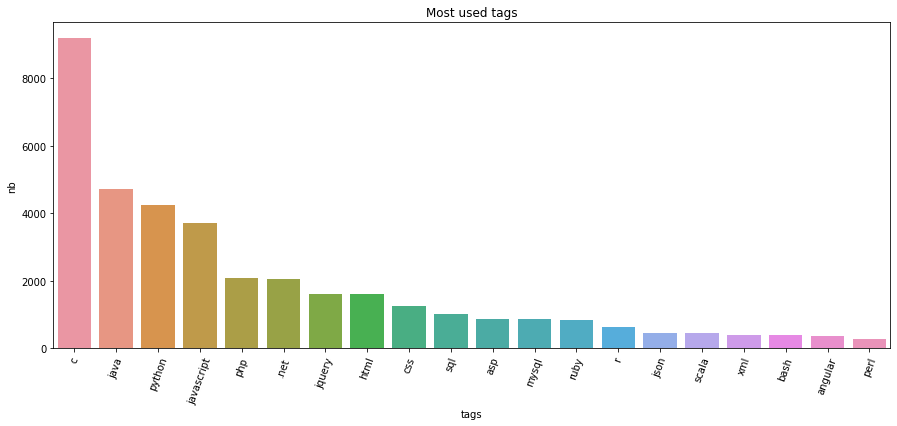

In [44]:
# Plot the top 20 of the most used tags 
fig = plt.figure(figsize=(15, 6))
sns.barplot(data=count_tags_prog[:20], x='tags', y='nb')
plt.title('Most used tags')
plt.xticks(rotation=70)
plt.show()

### Pipeline

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [3]:
import re


def check_tag(word, list_tags):
    """check if the word is ont one tags from the tags list and return its simplified form"""
    for t in list_tags:
        if word == t:
            simple_t = re.match('(\.?[a-z]+)', t).group()
            return (True, simple_t)
    return (False, '')


def simplify_tags_sentence(s, list_tags):
    """simplify a sentence of tags removing tags that dont belong to list_tags"""
    l = []
    for w in s.split(' '):
        b, x = check_tag(w, list_tags)
        if b:
            l.append(x)
    return l


def check_sentence(s, list_tags):
    """check if the sequence of tags s has one tag in the list_tags"""
    for w in s.split(' '):
        a, x = check_tag(w, list_tags)
        if a:
            return a
    return False

In [25]:
stop = stopwords.words('english')


def remove_stopwords_sentence(sentence):
    """remove stopwords from sentence"""
    return pd.Series([word for word in sentence[0].split() if word not in stop])


def remove_stopwords_df(df):
    """remove stopwords from a dataframe"""
    return df.apply(remove_stopwords_sentence, axis=1)


def stem_sentence(s):
    """ stem sentence"""
    stemmer = EnglishStemmer()
    return pd.Series([stemmer.stem(w) for w in s if not pd.isna(w)])


# body and title
body_title_pipeline = Pipeline(steps=[
    ('remove html tags', FunctionTransformer(pd.DataFrame.replace,
                                             kw_args={'to_replace': '<.*?>', 'value': '', 'regex': True})),
    ('lower', FunctionTransformer(lambda x: x.squeeze(axis=1).str.lower().to_frame())),
    ('remove punctuation', FunctionTransformer(lambda x: x.squeeze(
        axis=1).str.replace('[{}]'.format(punctuation), '').to_frame())),
    ('remove stopwords', FunctionTransformer(remove_stopwords_df, validate=False)),
    ('stemming', FunctionTransformer(pd.DataFrame.apply, kw_args={
     'func': stem_sentence, 'axis': 1}, validate=False)),
    ('imputer', SimpleImputer(strategy='constant', fill_value=''))
])


# tags
tags_pipeline = Pipeline(steps=[
    ('remove <>', FunctionTransformer(lambda x: x.squeeze(
        axis=1).str.extractall(r'<(.*?)>').groupby(level=0).agg({0: ' '.join}))),
    ('lower', FunctionTransformer(lambda x: x.squeeze(axis=1).str.lower().to_frame())),
    ('split', FunctionTransformer(lambda x: x.squeeze(
        axis=1).apply(str.split).to_frame(), validate=False))
])

In [26]:
# apply tge pipeline on the body
preprocessor = ColumnTransformer(
    transformers=[
        ('body_title', body_title_pipeline, ['Title'])
    ])

In [27]:
df_proc = preprocessor.fit_transform(df_prog)

<ipython-input-25-f775599ec1dd>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series([word for word in sentence[0].split() if word not in stop])
<ipython-input-25-f775599ec1dd>:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series([stemmer.stem(w) for w in s if not pd.isna(w)])


In [37]:
df_proc.shape

(31666, 3154)

### TF IDF

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
# use the TF IDF on the body preprocessed
vectorizer = TfidfVectorizer(tokenizer=lambda i: i, lowercase=False)
X = vectorizer.fit_transform(df_proc)

#### PCA

In [29]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(100)
pca.fit(X)

TruncatedSVD(n_components=100)

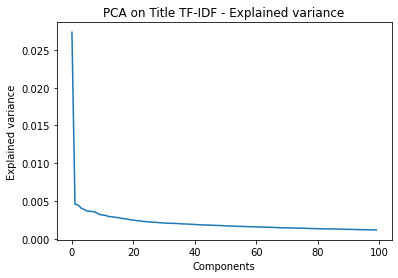

In [63]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Components')
plt.ylabel('Explained variance')
plt.title('PCA on Title TF-IDF - Explained variance')
plt.show()

In [59]:
def move_legend(ax, new_loc, **kws):
    """move the legend outside the plot, on the new_loc"""
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title,
              **kws, bbox_to_anchor=(1.2, 1))

In [32]:
# projeter X sur les composantes principales
X_projected = pca.transform(X)

In [33]:
list_tags = df_tags.Tags.to_list()
tags_prog = df_prog.tags_clean.apply(simplify_tags_sentence,list_tags=list_tags)

In [34]:
first_tags  =  tags_prog.apply(lambda x :x[0])

In [54]:
top_20_tags = count_tags_prog.tags[:10]

In [55]:
indices = first_tags.isin(top_20_tags.values)

In [56]:
X_projected[indices].shape

(25816, 100)

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


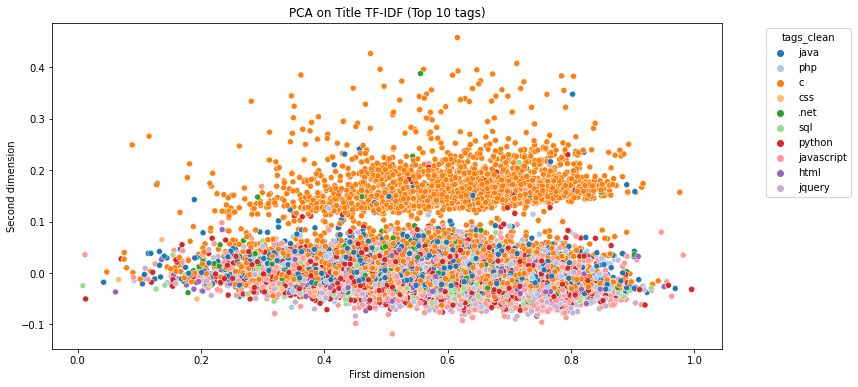

In [62]:
# plot the first 2 dimension of the PCA
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(X_projected[indices, 0], X_projected[indices,1], hue=first_tags[indices], palette='tab20')

move_legend(ax, "upper right")
plt.xlabel('First dimension')
plt.ylabel('Second dimension')
plt.title('PCA on Title TF-IDF (Top 10 tags)')
plt.show()